### Power-limits computation using the bisection method
The code in this notebook computes power limits for all points in time corresponding to a dynamic cell test.
It uses the bisection method -- first with ideal knowledge of cell state, and then with SPFK-estimated cell states instead. 

In [1]:
addpath ./readonly              % add helper functions to path
load ./readonly/CellModel.mat   % the ESC cell model
load ./readonly/CellData.mat    % the current/voltage profile
load ./readonly/spkfDataAll.mat % the SPFK-computed SOC state estimates, plus bounds, for this profile

In [2]:
% Search interval x1...x2 in fn h(.) for root, with tolerance tol
% The assumption is that h(x1) and h(x2) have different sign, and we
% are searching for a root between x1 and x2 where h(xmid) is 
% approximately zero.
% Special case: If h(x1) and h(x2) are both positive or both negative, 
% then function returns value within tol of x2
function x = bisect(h,x1,x2,tol)
  jmax = ceil(log2(abs(x2-x1)/tol));

  dx = x2 - x1; % set the search interval dx = x2 - x1; root b/w (x1,x1 + dx)
  if( h(x1) >= 0 )
    dx = -dx;
    x1 = x2;    % root still b/w (x1,x1 + dx), and h(x1) < 0 in normal case
  end
  
  for jj = 1:jmax
    dx   = 0.5 * dx;
    xmid = x1 + dx;

    if h(xmid) <= 0,
      x1 = xmid;
    end
  end
  x = x1 + 0.5*dx;
end

In [3]:
% Simulate a cell for K timesteps, with input ik and starting state x0
% x0 = [z0; ir0; h0]
function [vDT,xDT] = simCellKDT(ik,x0,A,B,KDT,T,model,R0,R,M,M0)

  % Form the "A" and "B" matrices needed
  Amat = A(ik); Bmat = B(ik); dA = diag(Amat);
  
  if ik == 0, % AK = matrix to multiply B and input (see lesson)
    ADT = diag([KDT, (1-dA(2)^KDT)/(1-dA(2)), KDT]);
  else
    ADT = diag([KDT, (1-dA(2)^KDT)/(1-dA(2)), (1-dA(3)^KDT)/(1-dA(3))]);
  end
  xDT = (dA).^KDT.*x0 + ADT*Bmat*[ik; sign(ik)]; % efficiently compute future state
  
  % Compute voltage based on future state
  vDT = OCVfromSOCtemp(xDT(1),T,model) + M*xDT(3) + M0*sign(ik) - R*xDT(2) - ik*R0;
end

In [4]:
% The bisection function to use to find discharge current
function h = bisectDischarge(ik,x0,A,B,KDT,T,model,R0,R,M,M0,minV,zmin) 
  [vDT,xDT] = simCellKDT(ik,x0,A,B,KDT,T,model,R0,R,M,M0);
  h = max(minV - vDT,zmin - xDT(1)); % max must be less than zero 
end

In [5]:
% The bisection function to use to find charge current
function h = bisectCharge(ik,x0,A,B,KDT,T,model,R0,R,M,M0,maxV,zmax)
  [vDT,xDT] = simCellKDT(ik,x0,A,B,KDT,T,model,R0,R,M,M0);
  h = min(maxV - vDT,zmax - xDT(1)); % min must be greater than zero
end

The next code cell sets up some constants for the bisection methods

In [6]:
% Cell Configuration
T       = 25;                                   % [C] ambient temperature
Thorz   = 15;                                   % [s] horizon time
Q       = getParamESC('QParam',T,model); 
RC      = getParamESC('RCParam',T,model);
R       = getParamESC('RParam',T,model);
R0      = getParamESC('R0Param',T,model);       
Gamma   = getParamESC('GParam',T,model);    
M       = getParamESC('MParam',T,model);       
M0      = getParamESC('M0Param',T,model);       

% Operational Limits
zmin = 0.1;     zmax = 0.9;                     % [u/l] soc limits
vmin = 2.8;     vmax = 4.3;                     % [V] voltage limits
imin = -200;    imax = 350;                     % [A] current limits
pmin = -inf;    pmax = inf;                     % [W] power limits

% Define inline functions A and B as functions of input current
A = @(ik) [1 0 0; 0 exp(-1/(RC)) 0; 0 0 exp(-abs(ik*Gamma/(3600*Q)))];
B = @(ik) [-1/(3600*Q) 0; (1-exp(-1/RC)) 0; 0 (exp(-abs(ik*Gamma/(3600*Q)))-1)];

The following code implements the bisection method over the entire profile, assuming exact knowledge of cell-model state at all points in time.

In [7]:
% Bisection Power Estimation: using true cell state

% Simulate cell over entire profile
fprintf('Beginning simCell state simulation.\n');
[vk,irck,hk,zk,OCV] = simCell(current,T,model,1,1,0,0);
fprintf('  simCell state simulation complete.\n');

% Reserve storage for computed results
pDisMax = zeros(length(current),1);
pChgMin = zeros(length(current),1);
fprintf('Beginning bisection method using true cell state.\n');
for ii = 1:length(current)
  x0 = [zk(ii); irck(ii); hk(ii)]; % state of cell at this point in time, from prior simulation
        
  % Discharge Power Estimation
  g = @(ik) bisectDischarge(ik,x0,A,B,Thorz,T,model,R0,R,M,M0,vmin,zmin); 
  iDisMax = 0;
  if zk(ii) > zmin,
    iDisMax = bisect(g,0,imax,0.5);
  end
  pDisMax(ii) = vmin*iDisMax;

  % Charge Power Estimation
  g = @(ik) bisectCharge(ik,x0,A,B,Thorz,T,model,R0,R,M,M0,vmax,zmax);
  iChgMin = 0;
  if zk(ii) < zmax,
    iChgMin = bisect(g,0,imin,0.5);
  end
  pChgMin(ii) = vmax*iChgMin;
  if mod(ii,1000) == 0,
    fprintf('  completed %d/%d iterations.\n',ii,length(current));
  end
end
truthBisect.pDisMax = pDisMax;
truthBisect.pChgMin = pChgMin;
fprintf('  bisection method using true cell state complete.\n');

Beginning simCell state simulation.
  simCell state simulation complete.
Beginning bisection method using true cell state.
  completed 1000/28510 iterations.
  completed 2000/28510 iterations.
  completed 3000/28510 iterations.
  completed 4000/28510 iterations.
  completed 5000/28510 iterations.
  completed 6000/28510 iterations.
  completed 7000/28510 iterations.
  completed 8000/28510 iterations.
  completed 9000/28510 iterations.
  completed 10000/28510 iterations.
  completed 11000/28510 iterations.
  completed 12000/28510 iterations.
  completed 13000/28510 iterations.
  completed 14000/28510 iterations.
  completed 15000/28510 iterations.
  completed 16000/28510 iterations.
  completed 17000/28510 iterations.
  completed 18000/28510 iterations.
  completed 19000/28510 iterations.
  completed 20000/28510 iterations.
  completed 21000/28510 iterations.
  completed 22000/28510 iterations.
  completed 23000/28510 iterations.
  completed 24000/28510 iterations.
  completed 25000/2851

The following code implements the bisection method over the entire profile, assuming SPKF-approximated knowledge of cell-model state at all points in time.

In [8]:
% Bisection Power Estimation: SPKF
% Note that [irck, irckBounds, hk, hkBounds, zk, zkBounds] pre-computed here by SPKF and loaded
% from spkfDataAll.mat to save processing time on Coursera web server

pDisMax = zeros(length(current),1);
pChgMin = zeros(length(current),1);
fprintf('Beginning bisection method using SPKF-estimated cell state.\n');
for ii = 1:length(current)
  % Discharge Power Estimation
  x0 = [zk(ii)-zkBounds(ii); irck(ii)+irckBounds(ii); (hk(ii)-hkBounds(ii))];
  g = @(ik) bisectDischarge(ik,x0,A,B,Thorz,T,model,R0,R,M,M0,vmin,zmin); 
  iDisMax = 0;
  if zk(ii)-zkBounds(ii)>zmin,
    iDisMax = bisect(g,0,imax,0.5);
  end
  pDisMax(ii) = vmin*iDisMax;

  % Charge Power Estimation
  x0 = [zk(ii)+zkBounds(ii); irck(ii)-irckBounds(ii); (hk(ii)+hkBounds(ii))];
  g = @(ik) bisectCharge(ik,x0,A,B,Thorz,T,model,R0,R,M,M0,vmax,zmax);
  iChgMin = 0;
  if zk(ii)+zkBounds(ii) < zmax,
    iChgMin = bisect(g,0,imin,0.5);
  end
  pChgMin(ii) = vmax*iChgMin;

  if mod(ii,1000) == 0,
    fprintf('  completed %d/%d iterations.\n',ii,length(current));
  end
end
spkfBisect.pDisMax = pDisMax;
spkfBisect.pChgMin = pChgMin;
fprintf('  bisection method using SPKF-estimated cell state complete.\n');

Beginning bisection method using SPKF-estimated cell state.
  completed 1000/28510 iterations.
  completed 2000/28510 iterations.
  completed 3000/28510 iterations.
  completed 4000/28510 iterations.
  completed 5000/28510 iterations.
  completed 6000/28510 iterations.
  completed 7000/28510 iterations.
  completed 8000/28510 iterations.
  completed 9000/28510 iterations.
  completed 10000/28510 iterations.
  completed 11000/28510 iterations.
  completed 12000/28510 iterations.
  completed 13000/28510 iterations.
  completed 14000/28510 iterations.
  completed 15000/28510 iterations.
  completed 16000/28510 iterations.
  completed 17000/28510 iterations.
  completed 18000/28510 iterations.
  completed 19000/28510 iterations.
  completed 20000/28510 iterations.
  completed 21000/28510 iterations.
  completed 22000/28510 iterations.
  completed 23000/28510 iterations.
  completed 24000/28510 iterations.
  completed 25000/28510 iterations.
  completed 26000/28510 iterations.
  completed 2

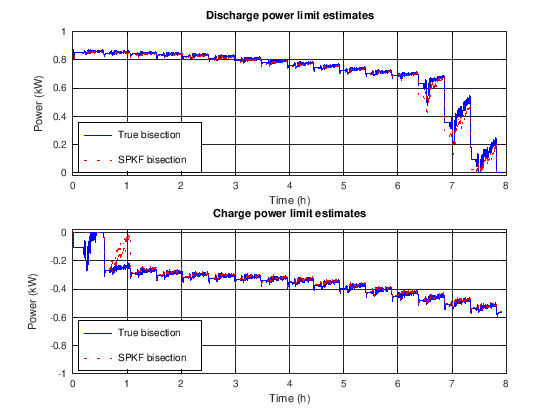

In [9]:
% Plot results
subplot(2,1,1);
plot(time/3600,truthBisect.pDisMax/1000,'b-','LineWidth',1.5); hold on
plot(time/3600,spkfBisect.pDisMax/1000,'r:','LineWidth',1.5);
xlabel('Time (h)'); ylabel('Power (kW)');
title('Discharge power limit estimates');
legend('True bisection','SPKF bisection','Location','SouthWest');
axis( [0 8.01 -0.02 1] );grid on;

subplot(2,1,2);
plot(time/3600,truthBisect.pChgMin/1000,'b-','LineWidth',1.5); hold on
plot(time/3600,spkfBisect.pChgMin/1000,'r:','LineWidth',1.5);
xlabel('Time (h)'); ylabel('Power (kW)');
title('Charge power limit estimates');
legend('True bisection','SPKF bisection','Location','SouthWest');
axis( [0 8.01 -1 0.02] ); grid on;

In [10]:
max(abs(truthBisect.pChgMin))
max(abs(spkfBisect.pChgMin))
max(abs(truthBisect.pDisMax))
max(abs(spkfBisect.pDisMax))

ans =  603.85
ans =  597.13
ans =  876.16
ans =  867.55
